In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [2]:
import keras_tuner as kt
from keras_tuner import RandomSearch
from GEH_LOSS import custom_loss
import geh as ga

In [3]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error

In [4]:
import relative_accuracy as ra

In [5]:
# Load all Inputs and Output Data

# 5 mins (1 step ahead)
Deep_train_5   = np.load("Deep_train_5_multi.npz")['x'] 
Output_train_5 = np.load("Deep_train_5_multi.npz")['y']

Deep_test_5   = np.load("Deep_test_5_multi.npz")['x'] 
Output_test_5 = np.load("Deep_test_5_multi.npz")['y'] 

# 15 mins (3 steps ahead)
Deep_train_15   = np.load("Deep_train_15_multi.npz")['x'] 
Output_train_15 = np.load("Deep_train_15_multi.npz")['y']

Deep_test_15   = np.load("Deep_test_15_multi.npz")['x'] 
Output_test_15 = np.load("Deep_test_15_multi.npz")['y']

# 30 mins (6 steps ahead)
Deep_train_30   = np.load("Deep_train_30_multi.npz")['x'] 
Output_train_30 = np.load("Deep_train_30_multi.npz")['y']

Deep_test_30   = np.load("Deep_test_30_multi.npz")['x'] 
Output_test_30 = np.load("Deep_test_30_multi.npz")['y']

# 60 mins (12 steps ahead)
Deep_train_60   = np.load("Deep_train_60_multi.npz")['x'] 
Output_train_60 = np.load("Deep_train_60_multi.npz")['y']

Deep_test_60   = np.load("Deep_test_60_multi.npz")['x'] 
Output_test_60 = np.load("Deep_test_60_multi.npz")['y']

In [6]:
# Wide Data
Xtrain = joblib.load("002weeks_train_Multi.save") 
Xtest = joblib.load("002weeks_test_Multi.save") 

In [7]:
# 5 mins
# Delete first 15 samples
Wide_train_5 = np.delete(Xtrain, np.s_[0:15], 0)
Wide_test_5 = np.delete(Xtest, np.s_[0:15], 0)

In [8]:
# 15 mins
# Delete first 17 samples
Wide_train_15 = np.delete(Xtrain, np.s_[0:17], 0)
Wide_test_15 = np.delete(Xtest, np.s_[0:17], 0)

In [9]:
# 30 mins
# Delete first 20 samples
Wide_train_30 = np.delete(Xtrain, np.s_[0:20], 0)
Wide_test_30 = np.delete(Xtest, np.s_[0:20], 0)

In [10]:
# 60 mins
# Delete first 27 samples
Wide_train_60 = np.delete(Xtrain, np.s_[0:26], 0)
Wide_test_60 = np.delete(Xtest, np.s_[0:26], 0)

In [11]:
scaler_filename = "scaler.save"
scaler = joblib.load(scaler_filename) 

In [12]:
Test      = pd.read_csv('01test_scaled.csv', index_col=None, parse_dates=[0])

# Reshape Samples

The first step is to split the input sequences into subsequences that can be processed by the CNN model. Here, each spatio-temporal sample can be split into three sub-samples, each with five time steps. The CNN can interpret each subsequence of five time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

In [13]:
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6                # No of loop detectors
n_seq = 3                     # Subsequences
n_steps = 5                   # time-step per subsequence
# val_percent = 0.07567       # 2 weeks
val_percent = 0.2        
batch_size = 32

n_seq_ = 3                     # Subsequences
n_steps_ = 3                   # time-step per subsequence

#### 5 mins

In [14]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt5 = Deep_train_5.reshape((Deep_train_5.shape[0], n_seq, n_steps, n_features))
yt5 = scaler.inverse_transform(Output_train_5)

In [15]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv5 = Deep_test_5.reshape((Deep_test_5.shape[0], n_seq, n_steps, n_features))
yv5 = scaler.inverse_transform(Output_test_5)

#### 15 mins

In [16]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt15 = Deep_train_15.reshape((Deep_train_15.shape[0], n_seq, n_steps, n_features))
yt15 = scaler.inverse_transform(Output_train_15)

In [17]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv15 = Deep_test_15.reshape((Deep_test_15.shape[0], n_seq, n_steps, n_features))
yv15 = scaler.inverse_transform(Output_test_15)

#### 30 mins

In [18]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt30 = Deep_train_30.reshape((Deep_train_30.shape[0], n_seq, n_steps, n_features))
yt30 = scaler.inverse_transform(Output_train_30)

In [19]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv30 = Deep_test_30.reshape((Deep_test_30.shape[0], n_seq, n_steps, n_features))
yv30 = scaler.inverse_transform(Output_test_30)

#### 60 mins

In [20]:
# Train
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xt60 = Deep_train_60.reshape((Deep_train_60.shape[0], n_seq, n_steps, n_features))
yt60 = scaler.inverse_transform(Output_train_60)

In [21]:
# Test
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
Xv60 = Deep_test_60.reshape((Deep_test_60.shape[0], n_seq, n_steps, n_features))
yv60 = scaler.inverse_transform(Output_test_60)

### Reshaping the Data for Conv2D layer

For Conv2D, there is a need to add one more dimension to show we're dealing with 1 channel (since technically the images are in black and white, only showing values from 0-max flow on a single channel).

Conv1D - strides in 1 dimension
Conv2D - strides in 2 dimensions

In [22]:
# define no_of_channels
n_channels = 1

In [23]:
# Train data
Xt5  =  Xt5.reshape(Xt5.shape[0], n_seq, n_steps, n_features, n_channels)
Xt15 =  Xt15.reshape(Xt15.shape[0], n_seq, n_steps, n_features, n_channels)
Xt30 =  Xt30.reshape(Xt30.shape[0], n_seq, n_steps, n_features, n_channels)
Xt60 =  Xt60.reshape(Xt60.shape[0], n_seq, n_steps, n_features, n_channels)

# Validation data
Xv5  =  Xv5.reshape(Xv5.shape[0], n_seq, n_steps, n_features, n_channels)
Xv15 =  Xv15.reshape(Xv15.shape[0], n_seq, n_steps, n_features, n_channels)
Xv30 =  Xv30.reshape(Xv30.shape[0], n_seq, n_steps, n_features, n_channels)
Xv60 =  Xv60.reshape(Xv60.shape[0], n_seq, n_steps, n_features, n_channels)

In [24]:
Wt5  = Wide_train_5
Wt15 = Wide_train_15
Wt30 = Wide_train_30
Wt60 = Wide_train_60

Wv5  = Wide_test_5
Wv15 = Wide_test_15
Wv30 = Wide_test_30
Wv60 = Wide_test_60

In [25]:
# Train data
Wt5  =  Wt5.reshape(Wt5.shape[0], n_seq_, n_steps_, n_features, n_channels)
Wt15 =  Wt15.reshape(Wt15.shape[0], n_seq_, n_steps_, n_features, n_channels)
Wt30 =  Wt30.reshape(Wt30.shape[0], n_seq_, n_steps_, n_features, n_channels)
Wt60 =  Wt60.reshape(Wt60.shape[0], n_seq_, n_steps_, n_features, n_channels)

# Validation data
Wv5  =  Wv5.reshape(Wv5.shape[0], n_seq_, n_steps_, n_features, n_channels)
Wv15 =  Wv15.reshape(Wv15.shape[0], n_seq_, n_steps_, n_features, n_channels)
Wv30 =  Wv30.reshape(Wv30.shape[0], n_seq_, n_steps_, n_features, n_channels)
Wv60 =  Wv60.reshape(Wv60.shape[0], n_seq_, n_steps_, n_features, n_channels)

In [26]:
Xt5.shape

(49233, 3, 5, 6, 1)

In [27]:
Wt5.shape

(49233, 3, 3, 6, 1)

# CNN-LSTM model

In [28]:
from tensorflow import keras
from keras_self_attention import SeqSelfAttention

# Early Stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',patience=5, restore_best_weights = True)

In [29]:
Wide_train_5.shape

(49233, 9, 6)

# 5 mins ahead

In [30]:
def build_model_5(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt5.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt5.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_5w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_5 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, activation='relu', return_sequences=True),
        merge_mode="ave"
    )(flatten_5w)
    
    
    # Deep Model
    # CNN 
    CNN_5 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_5 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_5)
    # LSTM          
    LSTM_5 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_5)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_5, LSTM_5], axis=1)

    # Attention
    Att_5 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_5)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_5 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_5.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=custom_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                                   
    return model_5

In [31]:
tuner5 = RandomSearch(
    build_model_5,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8c-5",
)

In [32]:
tuner5.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [33]:
tuner5.search((Wt5,Xt5), yt5, epochs=200,
           validation_split = val_percent,
           callbacks = [early_stop],
           verbose=2)

Trial 60 Complete [00h 18m 21s]
val_loss: 0.45593658089637756

Best val_loss So Far: 0.2851945161819458
Total elapsed time: 18h 30m 07s
INFO:tensorflow:Oracle triggered exit


In [34]:
tuner5.results_summary(1)

Results summary
Results in C:\RunsOak\8c-5
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 4
filters: 384
kernel_size: 3
learning_rate: 0.0001
Score: 0.2851945161819458


### Best Model

In [35]:
best_hp5 = tuner5.get_best_hyperparameters()[0]
model5 = tuner5.hypermodel.build(best_hp5)

In [36]:
scaler_filename = "Best_HP/8c-5"
joblib.dump(best_hp5, scaler_filename) 

['Best_HP/8c-5']

In [37]:
model5.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 3, 4, 384  3840       ['DeepInput[0][0]']              
 buted)                         )                                                           

In [38]:
model5.fit((Wt5,Xt5), yt5, 
           epochs = 100, 
           verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 13s 7ms/step - loss: 0.9993 - mean_absolute_error: 144.9523 - root_mean_squared_error: 177.4239 - mean_absolute_percentage_error: 99.9257A: 7s - l
Epoch 2/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.8655 - mean_absolute_error: 120.4117 - root_mean_squared_error: 167.0376 - mean_absolute_percentage_error: 76.2253
Epoch 3/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.7112 - mean_absolute_error: 99.2605 - root_mean_squared_error: 162.8781 - mean_absolute_percentage_error: 57.4935
Epoch 4/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.6893 - mean_absolute_error: 99.4281 - root_mean_squared_error: 164.6935 - mean_absolute_percentage_error: 56.9938 0s - loss: 0.6898 - mean_absolute_error: 99.4716 - root_mean_squared_error: 164.7634 - mean_absolu
Epoch 5/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.6755 - mean_absolute_error: 99.236

1539/1539 [==============================] - 10s 7ms/step - loss: 0.4953 - mean_absolute_error: 74.8579 - root_mean_squared_error: 151.7420 - mean_absolute_percentage_error: 45.2788
Epoch 84/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.4941 - mean_absolute_error: 74.8139 - root_mean_squared_error: 151.6694 - mean_absolute_percentage_error: 45.2290
Epoch 85/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.4943 - mean_absolute_error: 74.8209 - root_mean_squared_error: 151.6672 - mean_absolute_percentage_error: 45.2868
Epoch 86/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.4945 - mean_absolute_error: 74.7316 - root_mean_squared_error: 151.5231 - mean_absolute_percentage_error: 45.1913 1s - loss: 0.4944 - mean_absolute_error: 74.8061 - root_mean_squar
Epoch 87/100
1539/1539 [==============================] - 10s 7ms/step - loss: 0.4946 - mean_absolute_error: 74.7551 - root_mean_squared_error: 151.5558 - mean_absolu

In [39]:
model5.save("my_dir/8c-5")

INFO:tensorflow:Assets written to: my_dir/8c-5\assets


INFO:tensorflow:Assets written to: my_dir/8c-5\assets


In [40]:
metrics5 = pd.DataFrame(model5.history.history)

<AxesSubplot:>

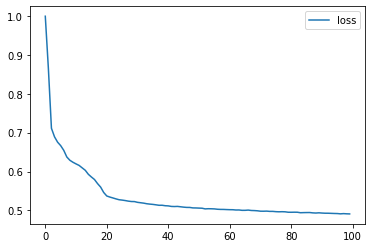

In [41]:
metrics5[['loss']].plot()

In [42]:
model5 = keras.models.load_model("my_dir/8c-5", custom_objects={'custom_loss': custom_loss}) 

In [43]:
model5.predict((Wv5,Xv5))

array([[ 31.298801 ,  19.835503 ,  19.305712 , -10.650746 ,  34.74335  ,
          6.221398 ],
       [ 29.712725 ,  17.94663  ,  18.587648 , -10.497279 ,  34.331093 ,
          6.2054   ],
       [ 29.740149 ,  17.935604 ,  17.29424  ,  -9.677536 ,  32.36238  ,
          5.998132 ],
       ...,
       [ 43.922157 ,  40.240116 ,  69.34001  , -23.590532 ,  51.993885 ,
          4.897752 ],
       [ 43.476948 ,  38.621346 ,  61.517796 , -20.37758  ,  46.806213 ,
          4.3963923],
       [ 42.072166 ,  38.63112  ,  54.673016 , -18.349268 ,  44.789227 ,
          4.7979603]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions5 = model5.predict((Wv5,Xv5))


MSE5 = mean_squared_error(yv5,test_predictions5)

MAE5 = mean_absolute_error(yv5,test_predictions5)

RMSE5 = np.sqrt(MSE5)

MAPE5 = mean_absolute_percentage_error(yv5,test_predictions5)*100

eval5 = [MSE5, MAE5, RMSE5, MAPE5]
print(eval5)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv5), np.asarray(test_predictions5))
GEH5 = count/GEH.size
print(GEH5)

# 15 mins ahead

In [46]:
def build_model_15(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt15.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt15.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_15w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_15 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, activation='relu', return_sequences=True),
        merge_mode="ave"
    )(flatten_15w)
    
    
    # Deep Model
    # CNN 
    CNN_15 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_15 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_15)
    # LSTM          
    LSTM_15 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_15)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_15, LSTM_15], axis=1)

    # Attention
    Att_15 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_15)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_15 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_15.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=custom_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_15

In [47]:
tuner15 = RandomSearch(
    build_model_15,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8c-15",
)

In [48]:
tuner15.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [49]:
tuner15.search((Wt15,Xt15), yt15, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop], 
            verbose=2)

Trial 60 Complete [00h 25m 31s]
val_loss: 0.40817923843860626

Best val_loss So Far: 0.3603269159793854
Total elapsed time: 12h 29m 18s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [50]:
tuner15.results_summary(1)

Results summary
Results in C:\RunsOak\8c-15
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 63
filters: 448
kernel_size: 2
learning_rate: 0.001
Score: 0.3603269159793854


### Best model

In [51]:
best_hp15 = tuner15.get_best_hyperparameters()[0]
model15 = tuner15.hypermodel.build(best_hp5)

In [52]:
scaler_filename = "Best_HP/8c-15"
joblib.dump(best_hp15, scaler_filename) 

['Best_HP/8c-15']

In [53]:
model15.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 3, 4, 384  3840       ['DeepInput[0][0]']              
 buted)                         )                                                           

In [54]:
model15.fit((Wt15,Xt15), yt15, 
            epochs = 100,
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 12s 6ms/step - loss: 0.9994 - mean_absolute_error: 144.9618 - root_mean_squared_error: 177.4235 - mean_absolute_percentage_error: 99.9240
Epoch 2/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.9728 - mean_absolute_error: 142.3167 - root_mean_squared_error: 175.4934 - mean_absolute_percentage_error: 95.5918
Epoch 3/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.8946 - mean_absolute_error: 124.7758 - root_mean_squared_error: 164.6678 - mean_absolute_percentage_error: 81.9870
Epoch 4/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.7287 - mean_absolute_error: 95.6735 - root_mean_squared_error: 146.9799 - mean_absolute_percentage_error: 61.3758
Epoch 5/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.7036 - mean_absolute_error: 89.3651 - root_mean_squared_error: 137.7815 - mean_absolute_percentage_error: 58.1552
Epoch 6/100
1539/1539 [========

1539/1539 [==============================] - 9s 6ms/step - loss: 0.4647 - mean_absolute_error: 45.3042 - root_mean_squared_error: 92.9286 - mean_absolute_percentage_error: 40.4067
Epoch 81/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.4645 - mean_absolute_error: 45.4006 - root_mean_squared_error: 93.2286 - mean_absolute_percentage_error: 40.2053
Epoch 82/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.4647 - mean_absolute_error: 45.3400 - root_mean_squared_error: 93.0722 - mean_absolute_percentage_error: 40.4052A: 6s - loss: 0.4640 - mea
Epoch 83/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.4634 - mean_absolute_error: 45.2952 - root_mean_squared_error: 93.0131 - mean_absolute_percentage_error: 40.3232
Epoch 84/100
1539/1539 [==============================] - 9s 6ms/step - loss: 0.4634 - mean_absolute_error: 45.2829 - root_mean_squared_error: 92.9958 - mean_absolute_percentage_error: 40.3693
Epoch 85/100
1539/1539

In [55]:
model15.save("my_dir/8c-15")

INFO:tensorflow:Assets written to: my_dir/8c-15\assets


INFO:tensorflow:Assets written to: my_dir/8c-15\assets


In [56]:
metrics15 = pd.DataFrame(model15.history.history)

<AxesSubplot:>

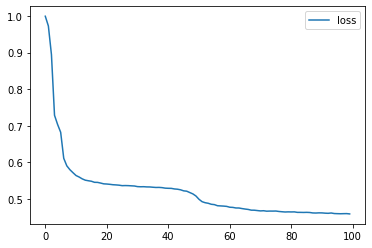

In [57]:
metrics15[['loss']].plot()

In [58]:
model15 = keras.models.load_model("my_dir/8c-5", custom_objects={'custom_loss': custom_loss})

In [59]:
model15.predict((Wv15,Xv15))

array([[ 31.264935 ,  19.64991  ,  19.304552 , -10.533635 ,  34.61382  ,
          6.2362623],
       [ 29.700733 ,  17.959633 ,  18.573256 , -10.495458 ,  34.299274 ,
          6.1963515],
       [ 29.723057 ,  17.868368 ,  17.269934 ,  -9.646727 ,  32.324917 ,
          5.99601  ],
       ...,
       [ 50.592964 ,  48.080578 ,  73.54753  , -27.856344 ,  58.951893 ,
          6.8320208],
       [ 48.13155  ,  44.384895 ,  72.21135  , -26.370714 ,  56.564537 ,
          6.4021935],
       [ 44.023434 ,  38.88681  ,  68.81243  , -22.87929  ,  51.194366 ,
          4.891654 ]], dtype=float32)

### Evaluation on inverse_transform

In [ ]:
test_predictions15 = model15.predict((Wv15,Xv15))


MSE15 = mean_squared_error(yv15,test_predictions15)

MAE15 = mean_absolute_error(yv15,test_predictions15)

RMSE15 = np.sqrt(MSE15)

MAPE15 = mean_absolute_percentage_error(yv15,test_predictions15)*100

eval15 = [MSE15, MAE15, RMSE15, MAPE15]
print(eval15)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv15), np.asarray(test_predictions15))
GEH15 = count/GEH.size
print(GEH15)

# 30 mins ahead

In [62]:
def build_model_30(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt30.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt30.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_30w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_30 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, activation='relu', return_sequences=True),
        merge_mode="ave"
    )(flatten_30w)
    
    
    # Deep Model
    # CNN 
    CNN_30 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_30 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_30)
    # LSTM          
    LSTM_30 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_30)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_30, LSTM_30], axis=1)

    # Attention
    Att_30 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_30)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_30 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_30.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=custom_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_30

In [63]:
tuner30 = RandomSearch(
    build_model_30,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8c-30",
)

In [64]:
tuner30.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 100, 'step': 1, 'sampling': None}
filters (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
kernel_size (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3], 'ordered': True}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [65]:
tuner30.search((Wt30,Xt30), yt30, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

Trial 60 Complete [00h 32m 49s]
val_loss: 0.41434861719608307

Best val_loss So Far: 0.3952670693397522
Total elapsed time: 13h 46m 35s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [66]:
tuner30.results_summary(1)

Results summary
Results in C:\RunsOak\8c-30
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 45
filters: 224
kernel_size: 3
learning_rate: 0.01
Score: 0.3952670693397522


### Best model

In [67]:
best_hp30 = tuner30.get_best_hyperparameters()[0]
model30 = tuner30.hypermodel.build(best_hp5)

In [68]:
scaler_filename = "8c-30"
joblib.dump(best_hp30, scaler_filename) 

['8c-30']

In [69]:
model30.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 DeepInput (InputLayer)         [(None, 3, 5, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 WideInput (InputLayer)         [(None, 3, 3, 6, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 time_distributed_4 (TimeDistri  (None, 3, 3, 4, 384  3840       ['DeepInput[0][0]']              
 buted)                         )                                                           

In [70]:
model30.fit((Wt30,Xt30), yt30, 
            epochs = 100, 
            verbose = 1)

Epoch 1/100
1539/1539 [==============================] - 13s 7ms/step - loss: 0.9993 - mean_absolute_error: 144.9458 - root_mean_squared_error: 177.3962 - mean_absolute_percentage_error: 99.9203
Epoch 2/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.9993 - mean_absolute_error: 144.8491 - root_mean_squared_error: 177.3049 - mean_absolute_percentage_error: 99.6966
Epoch 3/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.9453 - mean_absolute_error: 134.4908 - root_mean_squared_error: 167.4065 - mean_absolute_percentage_error: 88.2415
Epoch 4/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.9254 - mean_absolute_error: 125.2014 - root_mean_squared_error: 159.7020 - mean_absolute_percentage_error: 80.4172
Epoch 5/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.7834 - mean_absolute_error: 90.0675 - root_mean_squared_error: 130.8263 - mean_absolute_percentage_error: 56.8064
Epoch 6/100
1539/1539 [===

1539/1539 [==============================] - 11s 7ms/step - loss: 0.4936 - mean_absolute_error: 30.6547 - root_mean_squared_error: 52.4462 - mean_absolute_percentage_error: 33.6059
Epoch 84/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.4927 - mean_absolute_error: 30.6323 - root_mean_squared_error: 52.5229 - mean_absolute_percentage_error: 33.1727
Epoch 85/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.4910 - mean_absolute_error: 30.5309 - root_mean_squared_error: 52.4578 - mean_absolute_percentage_error: 32.8371
Epoch 86/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.4897 - mean_absolute_error: 30.3847 - root_mean_squared_error: 52.3139 - mean_absolute_percentage_error: 32.1435
Epoch 87/100
1539/1539 [==============================] - 11s 7ms/step - loss: 0.4876 - mean_absolute_error: 30.3087 - root_mean_squared_error: 52.2194 - mean_absolute_percentage_error: 30.9704
Epoch 88/100
1539/1539 [===================

KeyboardInterrupt: 

In [ ]:
model30.save("my_dir/8c-30")

In [ ]:
metrics30 = pd.DataFrame(model30.history.history)

In [ ]:
metrics30[['loss']].plot()

In [ ]:
model30 = keras.models.load_model("my_dir/8c-30", custom_objects={'custom_loss': custom_loss})

In [ ]:
model30.predict((Wv30,Xv30))

### Evaluation on inverse_transform

In [ ]:
test_predictions30 = model30.predict((Wv30,Xv30))


MSE30 = mean_squared_error(yv30,test_predictions30)

MAE30 = mean_absolute_error(yv30,test_predictions30)

RMSE30 = np.sqrt(MSE30)

MAPE30 = mean_absolute_percentage_error(yv30,test_predictions30)*100

eval30 = [MSE30, MAE30, RMSE30, MAPE30]
print(eval30)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv30), np.asarray(test_predictions30))
GEH30 = count/GEH.size
print(GEH30)

# 60 mins ahead

In [ ]:
def build_model_60(hp):
    # Inputs
    channel_Wide = keras.layers.Input(shape=Wt60.shape[1:], name="WideInput")
    channel_Deep = keras.layers.Input(shape=Xt60.shape[1:], name="DeepInput")
    units = hp.Int("units", min_value=1, max_value=100, step=1)
    
    
    # Wide Model
    flatten_60w = keras.layers.TimeDistributed(keras.layers.Flatten())(channel_Wide)
    Bi_60 = keras.layers.Bidirectional(
        keras.layers.LSTM(units=units, activation='relu', return_sequences=True),
        merge_mode="ave"
    )(flatten_60w)
    
    
    # Deep Model
    # CNN 
    CNN_60 = keras.layers.TimeDistributed(
        keras.layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=512, step=32),
                            kernel_size=hp.Choice("kernel_size", [2, 3]), activation='relu'))(channel_Deep)
    flatten_60 = keras.layers.TimeDistributed(keras.layers.Flatten())(CNN_60)
    # LSTM          
    LSTM_60 = keras.layers.LSTM(units=units, activation='relu', return_sequences=True)(flatten_60)

    
    # Concatenation 
    concat = keras.layers.concatenate([Bi_60, LSTM_60], axis=1)

    # Attention
    Att_60 = SeqSelfAttention(attention_activation='sigmoid')(concat)
    merge = keras.layers.Flatten()(Att_60)

    
    # Output
    output = keras.layers.Dense(n_features, name= "output")(merge)
    
    # Model
    model_60 = keras.Model(inputs=[channel_Wide,channel_Deep], outputs=[output])

    # Compile
    model_60.compile(optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])), 
        loss=custom_loss, metrics=['MeanAbsoluteError','RootMeanSquaredError','MeanAbsolutePercentageError'])
                    
    return model_60

In [ ]:
tuner60 = RandomSearch(
    build_model_60,
    objective="val_loss",
    max_trials=60,
    executions_per_trial=2,
    overwrite=True,
    directory=os.path.normpath('C:/RunsOak'),
    project_name="8c-60",
)

In [ ]:
tuner60.search_space_summary()

In [ ]:
tuner60.search((Wt60,Xt60), yt60, epochs=200,
            validation_split = val_percent,
            callbacks=[early_stop],
            verbose=2)

In [ ]:
tuner60.results_summary(1)

### Best model

In [ ]:
best_hp60 = tuner60.get_best_hyperparameters()[0]
model60 = tuner60.hypermodel.build(best_hp60)

In [ ]:
scaler_filename = "Best_HP/8c-60"
joblib.dump(best_hp60, scaler_filename) 

In [ ]:
model60.summary()

In [ ]:
model60.fit((Wt60,Xt60), yt60, 
            epochs = 100, 
            verbose = 1
            )

In [ ]:
model60.save("my_dir/8c-60")

In [ ]:
metrics60 = pd.DataFrame(model60.history.history)

In [ ]:
metrics60[['loss']].plot()

In [ ]:
model60 = keras.models.load_model("my_dir/8c-60", custom_objects={'custom_loss': custom_loss})

In [ ]:
model60.predict((Wv60,Xv60))

### Evaluation on inverse_transform

In [ ]:
test_predictions60 = model60.predict((Wv60,Xv60))


MSE60 = mean_squared_error(yv60,test_predictions60)

MAE60 = mean_absolute_error(yv60,test_predictions60)

RMSE60 = np.sqrt(MSE60)

MAPE60 = mean_absolute_percentage_error(yv60,test_predictions60)*100

eval60 = [MSE60, MAE60, RMSE60, MAPE60]
print(eval60)

In [ ]:
GEH, count = ga.GEH(np.asarray(yv60), np.asarray(test_predictions60))
GEH60 = count/GEH.size
print(GEH60)

# RESULTS

## General results

In [ ]:
l = ['MSE','MAE','RMSE','MAPE','Horizon']

In [ ]:
eval5.append(5)
eval15.append(15)
eval30.append(30)
eval60.append(60)

In [ ]:
df = pd.DataFrame(np.array([eval5,eval15,eval30,eval60]),columns=l)
df.set_index('Horizon')

## GEH

In [ ]:
n = [' 5 ',' 15 ',' 30 ',' 60 ']
df2 = pd.DataFrame(np.array([[GEH5, GEH15, GEH30, GEH60]]), columns=n)
print(df2)